<h1><center>Project Overview</center></h1><center>

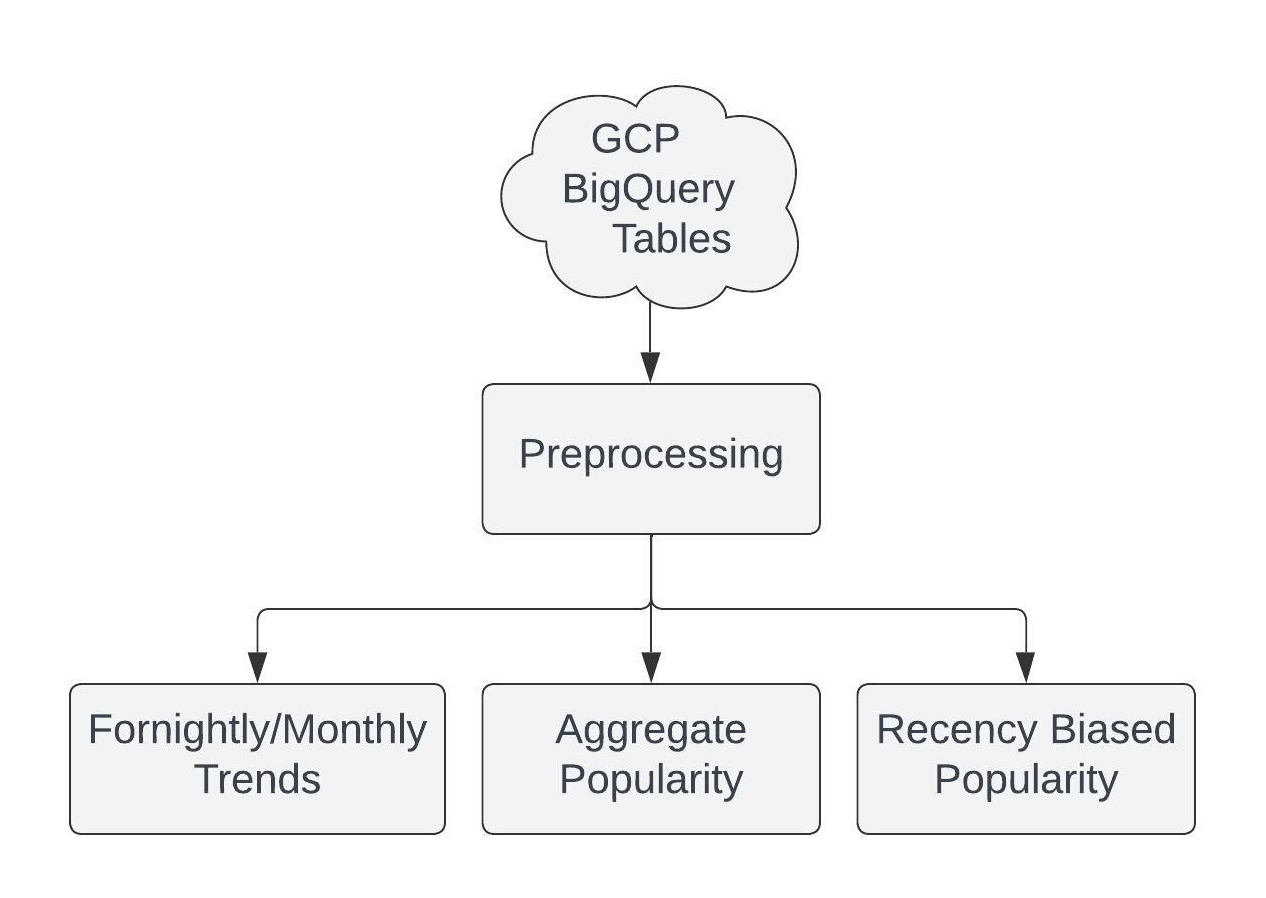</center>

## Issues and Tasks for sprint 1
<ol>
    <li> Develop the preprocessing pipeline <b>Done</b>
    <li> Develop the ML pipeline <b> Done </b>
    <li> Hyperparameter tuning <b> Done </b>
    <li> Issue: Very high multicollinearity in data -  Implemented XGBRegressor <b>Done</b>
    <li> Make a separate model for fornightly/monthly popularity - <b>Done</b>
</ol>
<h2>Tasks for sprint 2</h2>
<ol>
    <li> Induce Recency Bias for recently added products - <b>Logic Done. ML tuning in progress</b>
    <li> Create logging mechanism for the ML pipeline <b>In progress</b>
    <li> Use FIK to directly connect to GCP BigQuery Tables (Get access to FIK and set up)
    <li> Optimize the models using the sklearn.Pipeline package, and make the execution faster
    <li> Deploy
</ol>

In [6]:
import os
import sys
import pandas as pd
import numpy as np
import config as cfg
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import mean_absolute_error as mae
from xgboost import XGBRegressor
from xgboost import plot_importance


from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [7]:
cfg.ROOT_DIR


PosixPath('/Users/utkarsh.lal/Desktop/TIRA beauty PROD pipeline')

<h2> Preprocessing Function </h2>

In [8]:
# Preprocessing function
def preprocessing(clicks_path, wishlist_path, cart_path, orders_completed_path):
    
    #### Clicks ####
    df_clicks =  pd.read_csv(clicks_path)
    df_clicks.rename(columns={'f0_': 'product_id'}, inplace=True)
    df_clicks = df_clicks[['id', 'brand', 'category', 'event', 'event_text', 'name', 'original_timestamp', 'timestamp',\
                       'price', 'product_id', 'price']]
    
    # Brand wise aggregation
    df_clicks_brand = df_clicks.copy()
    df_clicks_brand['clicks'] = np.zeros(len(df_clicks_brand))
    df_clicks_brand = df_clicks_brand.groupby('brand', as_index=False).agg({'clicks': 'count'})

    # Mapping brands to categories
    brand_to_category_dict = dict(zip(df_clicks['brand'], df_clicks['category']))

    #### Orders completed ####
    df_order_completed = pd.read_csv(orders_completed_path)
    df_order_completed = df_order_completed[df_order_completed['products'].isnull() == False]
    df_order_completed = pd.concat([pd.DataFrame(eval(x)) for x in df_order_completed['products']], \
                               keys=df_order_completed['original_timestamp']).reset_index(level=1, drop=True).reset_index()
    df_order_completed = df_order_completed.fillna('0')
    for i, row in df_order_completed.iterrows():
        if (row['brand'] == '0'):
            row['brand'] = row['item_brand']
        if (row['name'] == '0'):
            row['name'] = row['item_name']
        if (row['product_id'] == '0'):
            row['product_id'] = row['item_id']
        if (row['category'] == '0'):
            if (row['brand'] in brand_to_category_dict.keys()):
                row['category'] = brand_to_category_dict[row['brand']]
        if (row['price'] == '0'):
            row['price'] = row['item_price']
        if (row['quantity'] == '0'):
            row['quantity'] = row['item_quantity']
    
    df_order_completed.drop(['item_brand', 'item_id', 'item_name', 'coupon', 'currency', 'category_id', 'image_url', 'size', 'item_price', 'item_quantity'], axis=1, inplace=True)
    df_order_completed['price'] = df_order_completed['price'].astype(float)
    df_order_completed['quantity'] = df_order_completed['quantity'].astype(float)

    df_order_completed['quantity'] = df_order_completed['quantity'].apply(lambda x: 1 if x == 0 else x)
    df_order_completed['category'] = df_order_completed['category'].apply(lambda x: 'not set' if x == '0' else x)

    # Brand wise aggregation
    df_order_completed_brand = df_order_completed.copy()
    df_order_completed_brand['no_of_unique_purchases'] = np.zeros(len(df_order_completed_brand))

    df_grouped = df_order_completed_brand.groupby('brand', as_index=False).agg({'price':'sum', 'quantity':'sum', 'no_of_unique_purchases': 'count'})
    df_grouped.rename(columns={'quantity':'no_of_purchases'}, inplace=True)
    df_grouped.sort_values(by='no_of_unique_purchases', ascending=False, inplace=True)
    df_order_completed_brand = df_grouped.copy()

    ### Wishlist ###
    df_wishlist_cart = pd.read_csv(wishlist_path)
    df_wishlist_cart.rename(columns={'f0_': 'product_id'}, inplace=True)

    # Brand wise aggregation
    df_wishlist = df_wishlist_cart
    df_wishlist_brand = df_wishlist.copy()
    df_wishlist_brand['no_of_adds_to_wishlist'] = np.zeros(len(df_wishlist_brand))
    df_grouped = df_wishlist_brand.groupby('brand', as_index=False)[['brand', 'no_of_adds_to_wishlist', 'price']].\
    agg({'price': 'sum', 'no_of_adds_to_wishlist': 'count'}).sort_values('no_of_adds_to_wishlist', ascending= False)
    df_wishlist_brand = df_grouped.copy()

    ### Cart ###
    df_cart = pd.read_csv(cart_path)
    df_cart_brand = df_cart.copy()
    df_cart_brand['no_of_adds_to_cart'] = np.zeros(len(df_cart_brand))
    df_cart_brand = df_cart_brand.groupby('brand', as_index=False)[['category', 'price', 'quantity', 'no_of_adds_to_cart']]\
        .agg({'price': 'sum', 'quantity': 'sum', 'no_of_adds_to_cart': 'count'}).sort_values('no_of_adds_to_cart', ascending=False)
    

    ### Joining All tables ###
    # Brand Tables
    df_joined_brand = df_clicks_brand.merge(df_order_completed_brand, on='brand', how='inner', suffixes=('', '_order_completes')).\
                                merge(df_wishlist_brand, on='brand', how='inner', suffixes=('', '_wishlist'))
    df_joined_brand = df_joined_brand.merge(df_cart_brand, on='brand', how='inner', suffixes=('', '_cart'))
    df_joined_brand.drop(['price', 'price_wishlist', 'price_cart', 'quantity'], axis=1, inplace=True)
    df_ml = df_joined_brand[['brand', 'clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_unique_purchases']].copy()
    normalize_cols = ['clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_unique_purchases']

    for column in normalize_cols:
        df_ml[column] = (df_ml[column] - df_ml[column].min()) / (df_ml[column].max() - df_ml[column].min())    
    df_ml = df_ml.dropna()
    df_ml.rename(columns={'no_of_adds_to_wishlist': 'adds_to_cart_from_wishlist'}, inplace=True)
    df_joined_brand.rename(columns={'no_of_adds_to_wishlist': 'adds_to_cart_from_wishlist'}, inplace=True)
    
    return df_ml, df_joined_brand

<h2> ML Pipeline </h2>

In [12]:
def train_compare_models():

    df_ml, df_joined_brand = preprocessing(cfg.clicks_path, cfg.wishlist_path, cfg.cart_path, cfg.order_completed_path)
    df_ml = df_ml.dropna()
    X = df_ml[['clicks', 'adds_to_cart_from_wishlist', 'no_of_adds_to_cart']]
    Y = df_ml['no_of_unique_purchases']
    x_train, x_test, y_train, y_test = train_test_split(X, Y,
                        test_size = 0.3, random_state = 123)
    

    #### Random Forest ####
    rf_reg = RandomForestRegressor()
    rf_reg.fit(x_train, y_train)
    train_score = rf_reg.score(x_train, y_train)

    rf_regressor = RandomForestRegressor(random_state = 123)

    params = {
        'bootstrap': [True],
        'max_depth': [None, 80],
        'max_features': [1, 2],
        'min_samples_leaf': [1, 3],
        'min_samples_split': [2, 8],
        'n_estimators': [100, 1000]
    }

    print('Fitting and tuning Random Forest')
    tuned_rf_regressor = GridSearchCV(estimator=rf_regressor, 
                    param_grid=params,
                    scoring='neg_mean_absolute_error', 
                    verbose=1, cv=15)


    tuned_rf_regressor.fit(x_train, y_train)
    #print("Best parameters for Random Forest:", tuned_rf_regressor.best_params_)
    #print("\nLowest MAE: ", (-tuned_xgb.best_score_)**(1/2.0))
    print("\nMAE: ", tuned_rf_regressor.best_score_)
    rf_mae = tuned_rf_regressor.best_score_

    #  Predicting the Test set results
    y_preds = tuned_rf_regressor.best_estimator_.predict(x_test)
    rf_test_accuracy = mae(y_test, y_preds)
    print(f"MAE for RF on the testing data: {rf_test_accuracy}")

    # Plotting the feature importance for RF
    importances = tuned_rf_regressor.best_estimator_.feature_importances_
    indices = np.argsort(importances)
    features = X.columns
    plt.figsize=(6,6)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.savefig(f'{cfg.PLOTS_DIR}/RF_Feature_Importance.png', bbox_inches='tight')

    plt.show()


    importances_rf = importances.copy()
    rf_imp = pd.DataFrame({'features': tuned_rf_regressor.best_estimator_.feature_names_in_, 'importance': tuned_rf_regressor.best_estimator_.feature_importances_})
    rf_imp.set_index('features', inplace=True)
    print(rf_imp)


    ### XGBoost ####
    xgb_reg = XGBRegressor()
    xgb_reg.fit(x_train, y_train)
    train_score = xgb_reg.score(x_train, y_train)
    
    print('****************\nFitting and tuning XGBoost')
    xgb = XGBRegressor(seed = 123)

    params = { 
        'max_depth': [3,6,10],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 500, 1000],
        'colsample_bytree': [0.3, 0.7]
    }


    tuned_xgb = GridSearchCV(estimator=xgb, 
                    param_grid=params,
                    scoring='neg_mean_absolute_error', 
                    verbose=1, cv=10)


    tuned_xgb.fit(x_train, y_train)
    #print("Best parameters:", tuned_xgb.best_params_)
    print("\nMAE: ", tuned_xgb.best_score_)
    xgb_mae = tuned_xgb.best_score_

    # Predicting the Test set results
    y_preds = tuned_xgb.best_estimator_.predict(x_test)
    xgb_test_accuracy = mae(y_test, y_preds)
    
    print(f"MAE for XGB on the testing data: {xgb_test_accuracy}")

    # Plotting xgb feature importance
    importances = tuned_xgb.best_estimator_.feature_importances_
    indices = np.argsort(importances)
    features = tuned_xgb.best_estimator_.feature_names_in_

    plt.figsize = (6,6)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='g', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.savefig(f"{cfg.PLOTS_DIR}/XGB_feature_importance.jpg", bbox_inches='tight')

    plt.show()

    importances_xgb = importances.copy()
    xgb_imp = pd.DataFrame({'features': tuned_xgb.best_estimator_.feature_names_in_, 'importance': tuned_xgb.best_estimator_.feature_importances_})
    xgb_imp
    xgb_imp.set_index('features', inplace=True)

    print(xgb_imp)

    if (rf_test_accuracy < xgb_test_accuracy):
        print("Random Forest is giving better performance on Regression")
        df_X = df_joined_brand[['brand', 'clicks', 'adds_to_cart_from_wishlist', 'no_of_adds_to_cart', 'no_of_purchases']].copy()

        df_X = df_joined_brand.apply(lambda x: (x-x.min())/(x.max()-x.min()) if(type(x[0]) != str) else x)
        if (max(rf_imp['importance']) > 0.5):
            w_purchase = max(rf_imp['importance']) - 0.15
        else:
            w_purchase = max(rf_imp['importance']) + 0.15
        w_clicks = rf_imp.loc['clicks', 'importance'] * (1 - w_purchase)
        w_wishlist = rf_imp.loc['adds_to_cart_from_wishlist', 'importance'] * (1 - w_purchase)
        w_cart = rf_imp.loc['no_of_adds_to_cart', 'importance'] * (1 - w_purchase)
        df_popularity_fin = df_X
        df_popularity_fin['popularity_score'] = (df_X['no_of_purchases'] * w_purchase + df_X['clicks'] * w_clicks + df_X['adds_to_cart_from_wishlist'] * w_wishlist + df_X['no_of_adds_to_cart'] * w_cart)/(w_purchase + w_clicks + w_wishlist + w_cart)
        df_popularity_fin.sort_values('popularity_score', ascending=False, inplace=True)
        df_popularity_fin.to_csv('Output/popularity_score.csv', index=False)

        return df_popularity_fin

    else:
        print("XGBoost is giving better performance on Regression")
        df_X = df_joined_brand[['brand', 'clicks', 'adds_to_cart_from_wishlist', 'no_of_adds_to_cart', 'no_of_purchases']].copy()

        df_X = df_joined_brand.apply(lambda x: (x-x.min())/(x.max()-x.min()) if(type(x[0]) != str) else x)
        if (max(xgb_imp['importance']) > 0.5):
            w_purchase = max(xgb_imp['importance']) - 0.15
        else:
            w_purchase = max(xgb_imp['importance']) + 0.15
        w_clicks = xgb_imp.loc['clicks', 'importance'] * (1 - w_purchase)
        w_wishlist = xgb_imp.loc['adds_to_cart_from_wishlist', 'importance'] * (1 - w_purchase)
        w_cart = xgb_imp.loc['no_of_adds_to_cart', 'importance'] * (1 - w_purchase)
        df_popularity_fin = df_X

        df_popularity_fin['popularity_score'] = (df_X['no_of_purchases'] * w_purchase + df_X['clicks'] * w_clicks + df_X['adds_to_cart_from_wishlist'] * w_wishlist + df_X['no_of_adds_to_cart'] * w_cart)/(w_purchase + w_clicks + w_wishlist + w_cart)
        df_popularity_fin.sort_values('popularity_score', ascending=False, inplace=True)
        df_popularity_fin.to_csv(f'{cfg.OUTPUT_DIR}/popularity_score.csv', index=False)

        return df_popularity_fin



<h2> Output </h2>

Fitting and tuning Random Forest
Fitting 15 folds for each of 32 candidates, totalling 480 fits

MAE:  -0.023557670936971267
MAE for RF on the testing data: 0.03361201784271967


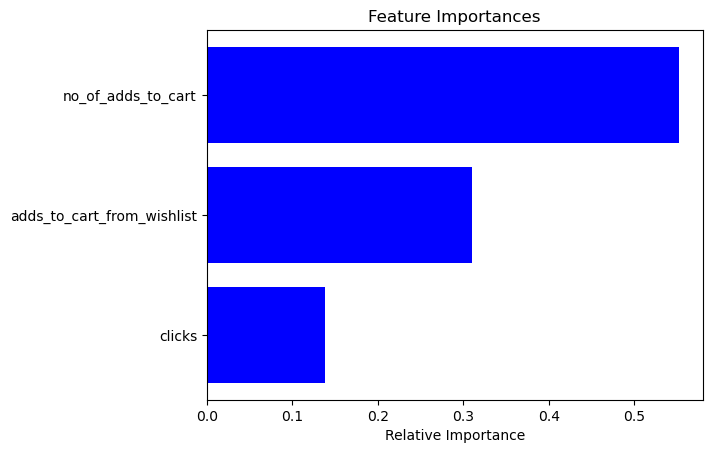

                            importance
features                              
clicks                        0.138287
adds_to_cart_from_wishlist    0.309573
no_of_adds_to_cart            0.552140
****************
Fitting and tuning XGBoost
Fitting 10 folds for each of 54 candidates, totalling 540 fits

MAE:  -0.027537390111418803
MAE for XGB on the testing data: 0.03425670949616105


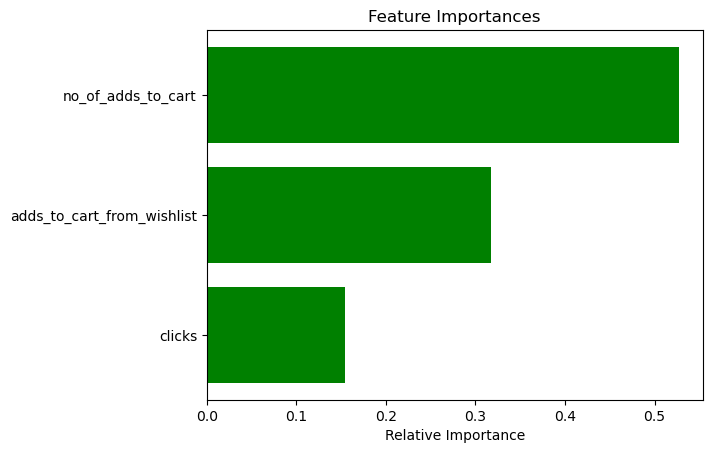

                            importance
features                              
clicks                        0.154850
adds_to_cart_from_wishlist    0.317688
no_of_adds_to_cart            0.527462
Random Forest is giving better performance on Regression


,brand,clicks,no_of_purchases,no_of_unique_purchases,adds_to_cart_from_wishlist,no_of_adds_to_cart,popularity_score
68,Colorbar,0.700315,0.662857,0.701075,1.000000,1.000000,0.839644
154,Lakme,0.762362,1.000000,1.000000,0.611321,0.493019,0.741060
168,M.A.C,0.982785,0.558095,0.462366,0.754717,0.878219,0.735272
181,Maybelline New York,1.000000,0.655238,0.662366,0.573585,0.550419,0.634028
229,Plum,0.337338,0.649524,0.658065,0.633962,0.477816,0.564152
...,...,...,...,...,...,...,...
37,Bhu Botanicals,0.000879,0.000000,0.000000,0.000000,0.000776,0.000329
169,MADES,0.001319,0.000000,0.000000,0.000000,0.000621,0.000314
51,BrownSkin Beauty,0.000806,0.000000,0.000000,0.000000,0.000621,0.000271
236,Qurez,0.000879,0.000000,0.000000,0.000000,0.000465,0.000226


In [13]:
train_compare_models()

<h2>1. Product Clicks </h2>

In [12]:
df_clicks =  pd.read_csv("Tables/prod_product_viewed.csv")
df_clicks.rename(columns={'f0_': 'product_id'}, inplace=True)

In [13]:
df_clicks = df_clicks[['id', 'brand', 'category', 'event', 'event_text', 'name', 'original_timestamp', 'timestamp',\
                       'price', 'product_id', 'price']]
df_clicks

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,price
0,ajs-next-fb31736eeff5cf0a9bd64c5e43fb36e4,Colorbar,Womens Body Mist & Sprays,product_viewed,Product Viewed,ColorBar Face & Body Refreshing Rose Mist - 00...,2022-11-04 08:59:49 UTC,2022-11-04 08:59:49.925 UTC,595.0,7506852.0,595.0
1,ajs-next-597d90c63455e7c351026c75acc2efd3,Amazon Series,Hair Mask,product_viewed,Product Viewed,Amazon Series Jojoba Daily Moisturizing Kerati...,2023-04-05 04:42:45.008 UTC,2023-04-05 04:42:45.648 UTC,1530.0,7533631.0,1530.0
2,ajs-next-ea1343ea1b399c2874953f1f1811578c,Re'equil,Hair Mask,product_viewed,Product Viewed,Re'equil Pea Protein & Ceramide Hair Mask (200g),2023-04-05 06:31:29.076 UTC,2023-04-05 06:31:29.239 UTC,741.0,7520641.0,741.0
3,ajs-next-d7270287719b7576696f7303123883d5,K18,Hair Masks,product_viewed,Product Viewed,K18 Leave-In Molecular Repair Hair Mask (50ml),2023-04-05 06:02:26.298 UTC,2023-04-05 06:02:26.453 UTC,5625.0,7542322.0,5625.0
4,ajs-next-164fc4c41e70e721d8f282941b6ed862,VGR,Trimmers,product_viewed,Product Viewed,VGR V-683 Trimmer 200 min Runtime 4 Length Set...,2023-02-17 03:14:59.482 UTC,2023-02-17 03:14:59.727 UTC,2999.0,7539543.0,2999.0
...,...,...,...,...,...,...,...,...,...,...,...
191387,C1C5ACCC-1CC6-4233-8ED5-686620AADF6C,AND,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,And Eternal Radiance EDP & Ethereal Dreamer ED...,2023-01-20 07:09:40.26 UTC,2023-01-20 07:09:40.494 UTC,1428.0,7539779.0,1428.0
191388,15B79289-9C39-4F55-9558-A4A72447F359,Boss,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Boss The Scent Private Accord For Her Eau De P...,2023-01-26 19:03:03.535 UTC,2023-01-26 19:03:04.006 UTC,8000.0,7506670.0,8000.0
191389,BAF1F886-0280-4861-9826-59F265DAD903,Paco Rabanne,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Paco Rabanne Pure XS for Her Eau De Parfum (50ml),2023-02-13 17:28:53.317 UTC,2023-02-13 17:28:53.563 UTC,5270.0,7506583.0,5270.0
191390,3a3f1f8e-d6e1-401b-a142-f165ad2be7dd,Carolina Herrera,Womens Perfumes (EDT & EDP),product_viewed,Product Viewed,Carolina Herrera Very Good Girl Eau De Parfum ...,2023-02-15 06:04:54.94 UTC,2023-02-15 06:04:56.617 UTC,8000.0,7506000.0,8000.0


In [14]:
df_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191392 entries, 0 to 191391
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  191392 non-null  object 
 1   brand               189153 non-null  object 
 2   category            189153 non-null  object 
 3   event               191392 non-null  object 
 4   event_text          191392 non-null  object 
 5   name                189126 non-null  object 
 6   original_timestamp  191392 non-null  object 
 7   timestamp           191392 non-null  object 
 8   price               189405 non-null  float64
 9   product_id          189134 non-null  float64
 10  price               189405 non-null  float64
dtypes: float64(3), object(8)
memory usage: 16.1+ MB


<h2>Brand-wise Clicks</h2>

In [15]:
df_clicks_brand = df_clicks.copy()
df_clicks_brand['brand'].value_counts()

Maybelline New York    13654
M.A.C                  13419
Lakme                  10410
Colorbar                9563
Estee Lauder            8405
                       ...  
Ivenross                   1
Chaitanya's                1
Pielor                     1
S-Shield                   1
Dorall Collection          1
Name: brand, Length: 728, dtype: int64

In [16]:
df_clicks_brand['clicks'] = np.zeros(len(df_clicks_brand))
df_clicks_brand = df_clicks_brand.groupby('brand', as_index=False).agg({'clicks': 'count'})
df_clicks_brand.sort_values('clicks', ascending=False)

,brand,clicks
428,Maybelline New York,13654
404,M.A.C,13419
376,Lakme,10410
153,Colorbar,9563
213,Estee Lauder,8405
...,...,...
135,Chaitanya's,1
596,Seyal Naturals,1
573,S-Shield,1
277,Hamam,1


<h2>Category-wise clicks<h2>

In [17]:
brand_to_category_dict = dict(zip(df_clicks['brand'], df_clicks['category']))
brand_to_category_dict

{'Colorbar': 'Body Wash & Shower Gel',
 'Amazon Series': 'Conditioner',
 "Re'equil": 'Serums & Essences',
 'K18': 'Hair Mask',
 'VGR': 'Trimmers',
 'Bobbi Brown': 'Face Moisturizer',
 'VI-JOHN': 'Aftershave Lotion',
 'Mancode': 'Serums & Essence',
 'Innisfree': 'Serums & Essences',
 'Wella Professionals': 'Conditioner',
 'GlowGlutathione': 'Multivitamins',
 'India Grooming Club': 'Mens Perfumes (EDT & EDP)',
 'Insight Cosmetics': 'Liquid Lipstick',
 'Dermalogica': 'Serums & Essences',
 'Vaseline': 'Body Wash & Shower Gel',
 'Estee Lauder': 'Womens Perfumes (EDT & EDP)',
 'Maybelline New York': 'Liquid Lipstick',
 '23 Yards': 'Hand Wash',
 'The Pink Foundry': 'Serums & Essences',
 'Mamaearth': 'Womens Perfumes (EDT & EDP)',
 'FOGG': 'Womens Perfumes (EDT & EDP)',
 'Blue Heaven': 'Liquid Lipstick',
 'RENEE': 'Liquid Lipstick',
 'KAMA Ayurveda': 'Body Wash & Shower Gel',
 'Lakme': 'Serums & Essences',
 'The Face Shop': 'Body Wash & Shower Gel',
 'Anastasia Beverly Hills': 'Liquid Lipstick

In [18]:
len(brand_to_category_dict.keys())

729

In [19]:
df_clicks_category = df_clicks.copy()
df_clicks_category['clicks'] = np.zeros(len(df_clicks_category))
df_clicks_category = df_clicks_category.groupby('category', as_index=False).agg({'clicks': 'count'})
df_clicks_category.sort_values('clicks', ascending=False)

,category,clicks
137,Lipstick,21594
92,Foundation,18165
138,Liquid Lipstick,15884
165,Nail Polish,7277
48,Concealer,6232
...,...,...
44,Butter,1
200,Stretch Mark Creams & Oil,1
142,Lotions & Creams,1
177,Salted Biscuits,1


<h2> 2. Order Completed </h2>

In [20]:
df_order_completed = pd.read_csv("Tables/prod_order_completed.csv")
df_order_completed = df_order_completed[df_order_completed['products'].isnull() == False]
df_order_completed

,id,event,event_text,original_timestamp,timestamp,products
0,ajs-next-80303a676f89ebb9036a491d95ab6570,order_completed,Order Completed,2023-03-19 20:10:06.213000 UTC,2023-03-19 20:10:06.469000 UTC,"[{""brand"":""SUGAR Cosmetics"",""name"":""Sugar All ..."
1,ajs-next-4fc10eaec64b82e00abc8467556856da,order_completed,Order Completed,2023-03-05 06:19:42.092000 UTC,2023-03-05 06:19:42.331000 UTC,"[{""brand"":""PAC"",""name"":""PAC Eyeliner Brush - 3..."
2,ajs-next-c1fd06c4e696a6b63bd1ee7622808c8b,order_completed,Order Completed,2023-02-22 14:16:32.534000 UTC,2023-02-22 14:16:32.790000 UTC,"[{""brand"":""COSRX"",""name"":""COSRX Low pH Good Mo..."
3,ajs-next-d8ede9207444f5e19fee52400e7dc85d,order_completed,Order Completed,2022-08-03 11:49:53.590000 UTC,2022-08-03 11:49:53.825000 UTC,"[{""item_brand"":""Colorbar"",""item_id"":7500059,""i..."
4,ajs-next-bcd8f02a519fddd307167edf6937d202,order_completed,Order Completed,2022-08-29 04:57:47.181000 UTC,2022-08-29 04:57:47.415000 UTC,"[{""item_brand"":""Elle 18"",""item_id"":7502715,""it..."
...,...,...,...,...,...,...
4685,B47DD5B2-2244-488A-8EEC-E995CEF2E3B6,order_completed,Order Completed,2023-01-09 12:07:23.722000 UTC,2023-01-09 12:07:25.435000 UTC,"[{""brand"":""Garnier"",""category"":""Hair Color"",""c..."
4686,7C73A28B-1BF5-4655-9A9E-8B709C8F746E,order_completed,Order Completed,2023-01-09 12:04:21.281000 UTC,2023-01-09 12:04:21.789000 UTC,"[{""brand"":""Garnier"",""category"":""Hair Color"",""c..."
4687,E908802F-8AA4-4A8D-8233-6DA842F39870,order_completed,Order Completed,2023-01-09 12:03:51.681000 UTC,2023-01-09 12:03:52.157000 UTC,"[{""brand"":""Garnier"",""category"":""Hair Color"",""c..."
4688,100A8806-B5D7-4C2C-BC52-ACDF42D55F58,order_completed,Order Completed,2023-01-07 17:05:24.484000 UTC,2023-01-07 17:05:24.614000 UTC,"[{""brand"":""Garnier"",""category"":""Hair Color"",""c..."


In [21]:
df_order_completed.iloc[2, 5]

'[{"brand":"COSRX","name":"COSRX Low pH Good Morning Gel Cleanser (150ml)","price":765,"product_id":7524037,"quantity":1},{"brand":"M.A.C","name":"M.A.C Mini Lipstick - Ruby Woo (1.8g)","price":715,"product_id":7526275,"quantity":1}]'

In [22]:
eval(df_order_completed.iloc[110, 5])

[{'brand': 'Clinic Plus',
  'category': 'Shampoo',
  'coupon': '',
  'name': 'Clinic Plus Strong & Long Health Shampoo (30ml)',
  'price': 10,
  'product_id': '7551959',
  'quantity': 1}]

In [23]:
df_order_completed = pd.concat([pd.DataFrame(eval(x)) for x in df_order_completed['products']], \
                               keys=df_order_completed['original_timestamp']).reset_index(level=1, drop=True).reset_index()
df_order_completed

,original_timestamp,brand,name,price,product_id,quantity,item_brand,item_id,item_name,category,coupon,currency,category_id,image_url,size,item_price,item_quantity
0,2023-03-19 20:10:06.213000 UTC,SUGAR Cosmetics,Sugar All Set To Go Banana Loose Powder - Beig...,599.0,7502478,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-03-05 06:19:42.092000 UTC,PAC,PAC Eyeliner Brush - 372 (1Pc),345.0,7541854,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-03-05 06:19:42.092000 UTC,CLINIQUE,Clinique Moisture Surge 100H Auto-Replenishing...,4100.0,7543048,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-03-05 06:19:42.092000 UTC,CLINIQUE,GWP CLINIQUE High Impact Mascara - Deluxe Samp...,0.0,7546267,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-02-22 14:16:32.534000 UTC,COSRX,COSRX Low pH Good Morning Gel Cleanser (150ml),765.0,7524037,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8917,2023-01-09 12:07:23.722000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN
8918,2023-01-09 12:04:21.281000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN
8919,2023-01-09 12:03:51.681000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN
8920,2023-01-07 17:05:24.484000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,NaN,NaN,NaN,Hair Color,,INR,NaN,NaN,NaN,NaN,NaN


In [24]:
df_order_completed = df_order_completed.fillna('0')
for i, row in df_order_completed.iterrows():
    if (row['brand'] == '0'):
        row['brand'] = row['item_brand']
    if (row['name'] == '0'):
        row['name'] = row['item_name']
    if (row['product_id'] == '0'):
        row['product_id'] = row['item_id']
    if (row['category'] == '0'):
        if (row['brand'] in brand_to_category_dict.keys()):
            row['category'] = brand_to_category_dict[row['brand']]
    if (row['price'] == '0'):
        row['price'] = row['item_price']
    if (row['quantity'] == '0'):
        row['quantity'] = row['item_quantity']

In [25]:
df_order_completed.drop(['item_brand', 'item_id', 'item_name', 'coupon', 'currency', 'category_id', 'image_url', 'size', 'item_price', 'item_quantity'], axis=1, inplace=True)

In [26]:
df_order_completed

,original_timestamp,brand,name,price,product_id,quantity,category
0,2023-03-19 20:10:06.213000 UTC,SUGAR Cosmetics,Sugar All Set To Go Banana Loose Powder - Beig...,599.0,7502478,1.0,Serums & Essences
1,2023-03-05 06:19:42.092000 UTC,PAC,PAC Eyeliner Brush - 372 (1Pc),345.0,7541854,1.0,Face Moisturizer
2,2023-03-05 06:19:42.092000 UTC,CLINIQUE,Clinique Moisture Surge 100H Auto-Replenishing...,4100.0,7543048,1.0,Womens Perfumes (EDT & EDP)
3,2023-03-05 06:19:42.092000 UTC,CLINIQUE,GWP CLINIQUE High Impact Mascara - Deluxe Samp...,0.0,7546267,1.0,Womens Perfumes (EDT & EDP)
4,2023-02-22 14:16:32.534000 UTC,COSRX,COSRX Low pH Good Morning Gel Cleanser (150ml),765.0,7524037,1.0,Face Moisturizer
...,...,...,...,...,...,...,...
8917,2023-01-09 12:07:23.722000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
8918,2023-01-09 12:04:21.281000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
8919,2023-01-09 12:03:51.681000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
8920,2023-01-07 17:05:24.484000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color


In [27]:
df_order_completed['price'] = df_order_completed['price'].astype(float)
df_order_completed['quantity'] = df_order_completed['quantity'].astype(float)

df_order_completed['quantity'] = df_order_completed['quantity'].apply(lambda x: 1 if x == 0 else x)
df_order_completed['category'] = df_order_completed['category'].apply(lambda x: 'not set' if x == '0' else x)
df_order_completed

,original_timestamp,brand,name,price,product_id,quantity,category
0,2023-03-19 20:10:06.213000 UTC,SUGAR Cosmetics,Sugar All Set To Go Banana Loose Powder - Beig...,599.0,7502478,1.0,Serums & Essences
1,2023-03-05 06:19:42.092000 UTC,PAC,PAC Eyeliner Brush - 372 (1Pc),345.0,7541854,1.0,Face Moisturizer
2,2023-03-05 06:19:42.092000 UTC,CLINIQUE,Clinique Moisture Surge 100H Auto-Replenishing...,4100.0,7543048,1.0,Womens Perfumes (EDT & EDP)
3,2023-03-05 06:19:42.092000 UTC,CLINIQUE,GWP CLINIQUE High Impact Mascara - Deluxe Samp...,0.0,7546267,1.0,Womens Perfumes (EDT & EDP)
4,2023-02-22 14:16:32.534000 UTC,COSRX,COSRX Low pH Good Morning Gel Cleanser (150ml),765.0,7524037,1.0,Face Moisturizer
...,...,...,...,...,...,...,...
8917,2023-01-09 12:07:23.722000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
8918,2023-01-09 12:04:21.281000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
8919,2023-01-09 12:03:51.681000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color
8920,2023-01-07 17:05:24.484000 UTC,Garnier,Garnier Men Shampoo Based Hair Color - Shade 3...,29.0,7505256,1.0,Hair Color


In [28]:
df_order_completed.sort_values('quantity', ascending=False)

,original_timestamp,brand,name,price,product_id,quantity,category
875,2023-04-05 14:16:28.384000 UTC,Garnier,Garnier Black Naturals Hair Colour - 2 Origina...,42.0,7539830,175.0,Hair Colour
6270,2023-04-04 18:36:36.846000 UTC,Mamaearth,Mamaearth Ubtan Face Scrub (100g),331.0,7521565,125.0,Scrubs & Exfoliators
3925,2023-02-16 17:41:05.721000 UTC,Dove,Dove Cream Beauty Bathing Bar Soap - (50g),27.0,7547386,100.0,Soaps
5417,2023-01-03 06:02:50.101000 UTC,Biotique,Biotique Basil & Parsley Revitalizing Bathing ...,60.0,7500872,44.0,Body Wash & Shower Gel
6881,2023-04-04 11:34:41.716000 UTC,Mamaearth,Mamaearth Onion Shampoo For Hair Growth & Hair...,659.0,7552525,36.0,Womens Perfumes (EDT & EDP)
...,...,...,...,...,...,...,...
3087,2023-03-08 08:46:09.642000 UTC,Minimalist,Minimalist Multi-vitamin SPF 50 PA ++++ Sunscr...,379.0,7531921,1.0,Serums & Essences
3086,2023-03-08 17:00:42.037000 UTC,Gillette,Gillette Mach 3 Manual Shaving Razor Blades Ca...,275.0,7547311,1.0,Razors & Cartridges
3085,2023-03-08 17:00:42.037000 UTC,Lakme,Lakme Absolute Hydra Pro Overnight Gel (50g),674.0,7539646,1.0,Serums & Essences
3084,2023-03-08 17:00:42.037000 UTC,St.Botanica,St.Botanica Moroccan Argan Oil Anti Wrinkle Re...,729.0,7538660,1.0,Body Wash & Shower Gel


<h2>Brand-wise</h2>

In [29]:
df_order_completed_brand = df_order_completed.copy()

In [30]:
df_order_completed_brand['no_of_unique_purchases'] = np.zeros(len(df_order_completed_brand))

df_grouped = df_order_completed_brand.groupby('brand', as_index=False).agg({'price':'sum', 'quantity':'sum', 'no_of_unique_purchases': 'count'})
df_grouped.rename(columns={'quantity':'no_of_purchases'}, inplace=True)
df_grouped.sort_values(by='no_of_unique_purchases', ascending=False, inplace=True)
df_grouped

,brand,price,no_of_purchases,no_of_unique_purchases
218,Lakme,136454.54,526.0,466
93,Colorbar,76673.30,349.0,327
266,Minimalist,159653.67,343.0,319
259,Maybelline New York,140812.45,345.0,309
324,Plum,112691.35,342.0,307
...,...,...,...,...
330,Profusion Cosmetics,1640.00,1.0,1
131,Fair And Handsome,210.00,1.0,1
334,QOD Professional,1500.00,1.0,1
337,Qurez,499.00,1.0,1


In [31]:
df_grouped[df_grouped['brand'] == 'Dove']

,brand,price,no_of_purchases,no_of_unique_purchases
113,Dove,21469.44,271.0,148


In [32]:
df_order_completed_brand = df_grouped.copy()

<h2>Category wise</h2>

In [33]:
df_order_completed_category = df_order_completed.copy()

In [34]:
df_order_completed_category['no_of_unique_purchases'] = np.zeros(len(df_order_completed_category))

df_grouped = df_order_completed_category.groupby('category', as_index=False).agg({'price':'sum', 'quantity':'sum', 'no_of_unique_purchases': 'count'})
df_grouped.rename(columns={'quantity':'no_of_purchases'}, inplace=True)
df_grouped.sort_values(by='no_of_unique_purchases', ascending=False, inplace=True)
df_grouped

,category,price,no_of_purchases,no_of_unique_purchases
147,Serums & Essences,783172.05,1577.0,1452
30,Body Wash & Shower Gel,303917.06,1047.0,892
114,Liquid Lipstick,288793.89,799.0,717
171,Womens Perfumes (EDT & EDP),529709.51,519.0,402
61,Face Moisturizer,343402.54,381.0,327
...,...,...,...,...
142,Pre & Post Shaves,406.00,1.0,1
115,Loofahs & Sponges,375.00,1.0,1
119,Makeup Pouches,1700.00,1.0,1
138,Nail Polish Sets,2500.00,1.0,1


In [35]:
df_order_completed_category = df_grouped.copy()

<h2> 3. Adds to Wishlist </h2>

In [36]:
# df_wishlist = pd.read_csv('Tables/prod_adds_to_wishlist.csv')
# df_wishlist

In [37]:
df_wishlist_cart = pd.read_csv('Tables/adds_to_cart_from_wishlist.csv')
df_wishlist_cart.rename(columns={'f0_': 'product_id'}, inplace=True)
# how to rename column of dataframe df_wishlist_cart
df_wishlist_cart

,id,event,event_text,original_timestamp,timestamp,brand,category,price,product_id,quantity
0,ajs-next-f2b51d028a2888968c72bbf92f6eb138,wishlist_product_added_to_cart,Wishlist Product Added to Cart,2023-03-06 07:06:19.806000 UTC,2023-03-06 07:06:21.578000 UTC,L’Oreal Paris,Hair Cream,499.0,7523440.0,1.0
1,ajs-next-073b164cb2ba35c186e0fb6b05a7eb49,wishlist_product_added_to_cart,Wishlist Product Added to Cart,2023-02-24 16:52:55.226000 UTC,2023-02-24 16:52:56.381000 UTC,BRYAN & CANDY,Gift Sets,900.0,7536772.0,1.0
2,ajs-next-f84f4b74c9fddf0a7bf285e481306ba9,wishlist_product_added_to_cart,Wishlist Product Added to Cart,2023-03-03 11:23:15.213000 UTC,2023-03-03 11:23:15.200000 UTC,Brut,Mens Deodorants & Roll-Ons,211.0,7548893.0,1.0
3,ajs-next-407a39dfdf21c16aacad62f00e3f81bf,wishlist_product_added_to_cart,Wishlist Product Added to Cart,2023-03-17 05:50:04.109000 UTC,2023-03-17 05:50:04.283000 UTC,Insight Cosmetics,Lip Liner,75.0,7515293.0,1.0
4,ajs-next-a8bf29e4c97ae2e3f86d276052cfd2fb,wishlist_product_added_to_cart,Wishlist Product Added to Cart,2023-03-26 19:50:17.403000 UTC,2023-03-26 19:50:17.599000 UTC,PAC,Sponges & Applicators,375.0,7541847.0,1.0
...,...,...,...,...,...,...,...,...,...,...
6208,436652f1-bafb-4767-ba4c-01fdb7f05d4a,wishlist_product_added_to_cart,Wishlist Product Added to Cart,2022-12-27 07:54:50.312000 UTC,2022-12-27 07:54:51.096000 UTC,Jaguar,Womens Perfumes (EDT & EDP),1650.0,7515981.0,1.0
6209,ajs-next-a927833ed6585f2ed6df2640f0de7e93,wishlist_product_added_to_cart,Wishlist Product Added to Cart,2023-01-10 06:58:32.414000 UTC,2023-01-10 06:58:32.872000 UTC,Global Desi,Womens Perfumes (EDT & EDP),1462.5,7539788.0,1.0
6210,ajs-next-1bea0ea296437370d338b69ba150a43e,wishlist_product_added_to_cart,Wishlist Product Added to Cart,2023-02-09 02:58:11.525000 UTC,2023-02-09 02:58:11.527000 UTC,FOGG,Womens Perfumes (EDT & EDP),599.0,7534857.0,1.0
6211,ajs-next-57569b29986ef33a046ed2d15fd9ff3a,wishlist_product_added_to_cart,Wishlist Product Added to Cart,2022-12-29 10:17:07.085000 UTC,2022-12-29 10:17:11.736000 UTC,Archies Parfum,Womens Perfumes (EDT & EDP),499.0,7528185.0,1.0


In [38]:
df_wishlist = df_wishlist_cart

<h2>Brand wise</h2>

In [39]:
df_wishlist_brand = df_wishlist.copy()

In [40]:
df_wishlist_brand['no_of_adds_to_wishlist'] = np.zeros(len(df_wishlist_brand))
df_grouped = df_wishlist_brand.groupby('brand', as_index=False)[['brand', 'no_of_adds_to_wishlist', 'price']].\
    agg({'price': 'sum', 'no_of_adds_to_wishlist': 'count'}).sort_values('no_of_adds_to_wishlist', ascending= False)
df_grouped

,brand,price,no_of_adds_to_wishlist
85,Colorbar,187155.9,266
208,M.A.C,372318.0,201
279,Plum,72872.0,169
194,Lakme,59405.5,163
222,Maybelline New York,78091.4,153
...,...,...,...
286,Quench Botanics,126.0,1
285,Pulp,1049.0,1
176,Kal Hans Naturals,400.0,1
178,Khadi Essentials,550.0,1


In [41]:
df_wishlist_brand = df_grouped.copy()

<h2>Category Wise</h2>

In [42]:
df_wishlist_category = df_wishlist.copy()

In [43]:
df_wishlist_category['no_of_adds_to_wishlist'] = np.zeros(len(df_wishlist_category))
df_grouped = df_wishlist_category.groupby('category', as_index=False)[['category', 'no_of_adds_to_wishlist', 'price']].\
    agg({'price': 'sum', 'no_of_adds_to_wishlist': 'count'}).sort_values('no_of_adds_to_wishlist', ascending= False)
df_grouped

,category,price,no_of_adds_to_wishlist
64,Foundation,447835.25,282
104,Lipstick,213793.00,246
105,Liquid Lipstick,123812.90,168
141,Shampoo,84350.17,152
35,Concealer,127002.60,146
...,...,...,...
124,Nail Art Kits,424.15,1
144,Shaving Foams,320.00,1
23,Body Lotions,154.00,1
142,Sharpeners,65.00,1


In [44]:
df_wishlist_category = df_grouped.copy()

<h2> 4. Adds to Cart </h2>

In [45]:
df_cart = pd.read_csv('tables/prod_adds_to_cart.csv')
df_cart

,id,brand,category,event,event_text,name,original_timestamp,timestamp,price,product_id,quantity
0,ajs-next-415c1a1b12b6a1446e186253ae8cdc19,SUGAR Cosmetics,Face Makeup Palettes,product_added,Product Added,Sugar Contour De Force Highlighter Palette - 0...,2022-08-16 14:58:56.69 UTC,2022-08-16 14:58:57.328 UTC,799.0,7501447.0,1.0
1,ajs-next-118db6a76344452f9a5526cb05fe29ff,Miss Claire,Lip Liner,product_added,Product Added,Miss Claire Glimmersticks Lipliner - L-13 Maro...,2023-02-23 16:45:32.466 UTC,2023-02-23 16:45:32.988 UTC,58.0,7503531.0,1.0
2,ajs-next-f7fbb744a2e1610bc9c13a0c8dc40d7b,Vega,Hair Combs,product_added,Product Added,"Set of 6 comb, (HCS-03)",2023-02-23 08:26:11.708 UTC,2023-02-23 08:26:11.741 UTC,280.0,7507866.0,1.0
3,ajs-next-d280035ee6e45211b2c7042945d9d2d1,Innisfree,BB & CC Creams,product_added,Product Added,Innisfree Simple Label Tinted Moisturizer 4 (T...,2023-02-23 16:24:59.958 UTC,2023-02-23 16:25:00.732 UTC,1370.0,7526419.0,1.0
4,ajs-next-06f62969f469d1b71f995a5ffc26c4dc,The Man Company,Moustache Oil,product_added,Product Added,The Man Company Moustache Growth Oil Roll-On (...,2023-01-16 08:19:08.985 UTC,2023-01-16 08:19:10.086 UTC,216.0,7533606.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
98429,de87db35-546e-4eb7-b09b-34ff3b8b3b0f,Vaseline,Body Lotions & Moisturisers,product_added,Product Added,Vaseline Intensive Care Deep Moisture Body Lot...,2023-04-04 17:43:18.058 UTC,2023-04-04 17:43:19.8 UTC,190.0,7527596.0,1.0
98430,7a3435a3-4356-4f86-9790-41839548d633,Plum,Body Lotions & Moisturisers,product_added,Product Added,Plum Bodylovin Hawaiian Rumba Colada Gel Lotio...,2023-03-17 09:12:21.196 UTC,2023-03-17 09:12:21.37 UTC,475.0,7527266.0,1.0
98431,F2670487-7E3E-44D4-B5B1-C503FAF45DEE,Vaseline,Body Lotions & Moisturisers,product_added,Product Added,Vaseline Calming Lavender Body Lotion - (400ml),2023-04-08 16:45:27.627 UTC,2023-04-08 16:45:28.103 UTC,449.0,7527289.0,1.0
98432,B6E9AB49-D809-4427-BEF8-E5C7C52D9D39,Suganda,Body Lotions & Moisturisers,product_added,Product Added,Suganda 5% Lactic Acid Body Lotion - (200ml),2023-04-04 03:23:51.53 UTC,2023-04-04 03:23:52.534 UTC,617.0,7527661.0,1.0


<h2>Brand Wise</h2>

In [46]:
df_cart_brand = df_cart.copy()
df_cart_brand['no_of_adds_to_cart'] = np.zeros(len(df_cart_brand))
df_cart_brand = df_cart_brand.groupby('brand', as_index=False)[['category', 'price', 'quantity', 'no_of_adds_to_cart']]\
    .agg({'price': 'sum', 'quantity': 'sum', 'no_of_adds_to_cart': 'count'}).sort_values('no_of_adds_to_cart', ascending=False)
df_cart_brand

,brand,price,quantity,no_of_adds_to_cart
139,Colorbar,17099064.0,24490.0,6448
365,M.A.C,35945563.0,19873.0,5663
387,Maybelline New York,6301327.0,16926.0,3550
340,Lakme,1254619.0,3746.0,3180
479,Plum,1705264.0,4107.0,3082
...,...,...,...,...
261,IKWI,525.0,1.0,1
539,Sebastian Professional,1800.0,1.0,1
282,It's Skin,1490.0,1.0,1
504,Rebloom,450.0,1.0,1


<h2>Category Wise</h2>

In [47]:
df_cart_category = df_cart.copy()
df_cart_category['no_of_adds_to_cart'] = np.zeros(len(df_cart_category))
df_cart_category = df_cart_category.groupby('category', as_index=False)[['category', 'price', 'quantity', 'no_of_adds_to_cart']]\
    .agg({'price': 'sum', 'quantity': 'sum', 'no_of_adds_to_cart': 'count'}).sort_values('no_of_adds_to_cart', ascending=False)
df_cart_category

,category,price,quantity,no_of_adds_to_cart
89,Foundation,21833143.0,24472.0,7290
134,Lipstick,12380377.0,12936.0,6405
176,Shampoo,4601767.0,21471.0,4342
174,Serums & Essences,9159937.0,7010.0,3982
74,Face Moisturiser,9061987.0,8216.0,3867
...,...,...,...,...
48,Condoms,357.0,3.0,2
50,Cream Biscuits,100.0,1.0,1
84,Firming Gels & Creams,880.0,1.0,1
4,Anti-Cellulite Creams,399.0,1.0,1


<h2> Joining All tables </h2>

In [48]:
# Brand Tables
df_joined_brand = df_clicks_brand.merge(df_order_completed_brand, on='brand', how='inner', suffixes=('', '_order_completes')).\
                            merge(df_wishlist_brand, on='brand', how='inner', suffixes=('', '_wishlist'))
df_joined_brand = df_joined_brand.merge(df_cart_brand, on='brand', how='inner', suffixes=('', '_cart'))
df_joined_brand

,brand,clicks,price,no_of_purchases,no_of_unique_purchases,price_wishlist,no_of_adds_to_wishlist,price_cart,quantity,no_of_adds_to_cart
0,18.21 Man Made,202,2400.00,1.0,1,43975.00,13,669450.0,167.0,156
1,23 Yards,28,598.00,29.0,3,858.00,3,85748.0,414.0,57
2,4711,32,0.00,1.0,1,3310.00,5,40892.0,55.0,43
3,A Fragrance Story,84,1877.00,3.0,3,699.00,1,30183.0,45.0,44
4,AND,431,24339.00,14.0,14,91982.00,49,3948257.0,2010.0,936
...,...,...,...,...,...,...,...,...,...,...
304,Xx Revolution,93,1590.00,2.0,2,3175.75,3,18529.0,17.0,17
305,YC,13,613.10,2.0,2,314.10,1,1866.0,6.0,6
306,Yves Rocher,645,31351.00,37.0,27,16132.00,9,1383015.0,845.0,581
307,ZM Zayn & Myza,191,2689.90,8.0,8,1030.00,5,27359.0,103.0,80


In [49]:
df_joined_brand.drop(['price', 'price_wishlist', 'price_cart', 'quantity'], axis=1, inplace=True)

df_joined_brand.sort_values('no_of_unique_purchases', ascending=False)

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart
154,Lakme,10410,526.0,466,163,3180
68,Colorbar,9563,349.0,327,266,6448
185,Minimalist,2647,343.0,319,97,2806
181,Maybelline New York,13654,345.0,309,153,3550
229,Plum,4608,342.0,307,169,3082
...,...,...,...,...,...,...
141,Kairali,48,1.0,1,5,25
153,Lacoste,62,1.0,1,5,26
281,The Tribe Concepts,40,1.0,1,1,6
232,Profusion Cosmetics,34,1.0,1,1,34


In [50]:
df_ml = df_joined_brand[['brand', 'clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_unique_purchases']].copy()
df_ml

,brand,clicks,no_of_adds_to_wishlist,no_of_adds_to_cart,no_of_unique_purchases
0,18.21 Man Made,202,13,156,1
1,23 Yards,28,3,57,3
2,4711,32,5,43,1
3,A Fragrance Story,84,1,44,3
4,AND,431,49,936,14
...,...,...,...,...,...
304,Xx Revolution,93,3,17,2
305,YC,13,1,6,2
306,Yves Rocher,645,9,581,27
307,ZM Zayn & Myza,191,5,80,8


In [51]:
normalize_cols = ['clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_unique_purchases']

for column in normalize_cols:
    df_ml[column] = (df_ml[column] - df_ml[column].min()) / (df_ml[column].max() - df_ml[column].min())    
df_ml = df_ml.dropna()
df_ml

,brand,clicks,no_of_adds_to_wishlist,no_of_adds_to_cart,no_of_unique_purchases
0,18.21 Man Made,0.014578,0.045283,0.023891,0.000000
1,23 Yards,0.001831,0.007547,0.008532,0.004301
2,4711,0.002124,0.015094,0.006361,0.000000
3,A Fragrance Story,0.005934,0.000000,0.006516,0.004301
4,AND,0.031353,0.181132,0.144896,0.027957
...,...,...,...,...,...
304,Xx Revolution,0.006593,0.007547,0.002327,0.002151
305,YC,0.000733,0.000000,0.000621,0.002151
306,Yves Rocher,0.047030,0.030189,0.089823,0.055914
307,ZM Zayn & Myza,0.013772,0.015094,0.012101,0.015054


In [52]:
df_ml.rename(columns={'no_of_adds_to_wishlist': 'adds_to_cart_from_wishlist'}, inplace=True)

In [53]:
df_ml = df_ml.dropna()

In [54]:
X = df_ml[['clicks', 'adds_to_cart_from_wishlist', 'no_of_adds_to_cart']]
Y = df_ml['no_of_unique_purchases']

In [55]:
#sns.heatmap(df_ml.corr(), annot=True)

In [56]:
#sns.pairplot(df_ml) 

# DO PIPELINE AND MINMAX SCALER IN PYTHON file

## PyCaret

In [47]:
from pycaret.regression import *

In [48]:
clf = setup(df_ml[['clicks', 'adds_to_cart_from_wishlist', 'no_of_adds_to_cart',\
                   'no_of_unique_purchases']], target = 'no_of_unique_purchases', session_id = 123)

In [48]:
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:09:31
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [47]:
ridge = create_model('ridge', fold=15)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:05:09
Status,. . . . . . . . . . . . . . . . . .,Fitting 15 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Ridge Regression


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0327,0.0034,0.0585,0.5523,0.0498,0.9421
1,0.0233,0.0008,0.0281,0.2637,0.0266,3.2211
2,0.0230,0.0009,0.0293,0.7179,0.0269,3.1864
3,0.0334,0.0024,0.0491,0.5743,0.0410,2.6967
4,0.0304,0.0025,0.0504,0.5605,0.0440,1.1342
5,0.0217,0.0006,0.0252,0.7294,0.0237,2.8396
6,0.0196,0.0005,0.0221,0.9408,0.0198,2.6998
7,0.0251,0.0007,0.0270,-0.3844,0.0264,3.0948
8,0.0289,0.0018,0.0429,0.8941,0.0329,3.5623


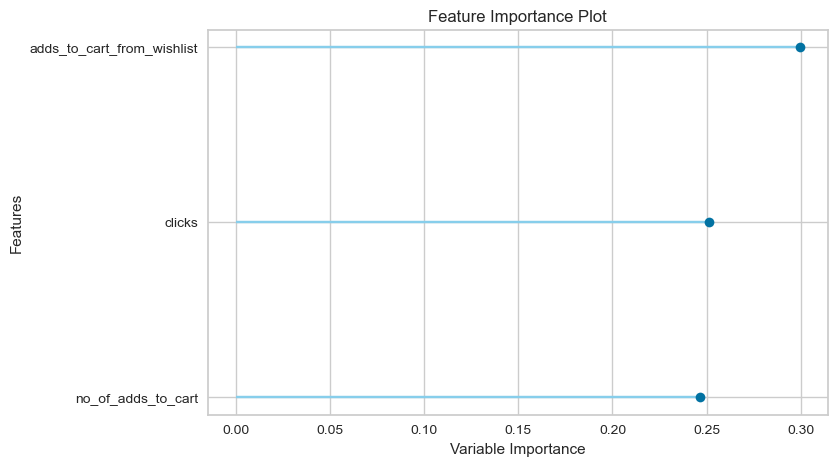

In [50]:
plot_model(ridge, plot = 'feature')

In [48]:
rf = create_model('rf', fold=10)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:05:16
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0245,0.0017,0.0415,0.7135,0.0357,0.4968
1,0.0132,0.0007,0.0272,0.6668,0.0235,0.9045
2,0.0262,0.0033,0.0575,0.3004,0.0446,0.9169
3,0.0208,0.0015,0.0381,0.7046,0.0328,0.5384
4,0.0088,0.0002,0.0140,0.9637,0.0132,0.7249
5,0.0208,0.0018,0.0420,0.8490,0.0327,1.3118
6,0.0267,0.0028,0.0528,0.7331,0.0439,1.0537
7,0.0578,0.0225,0.1500,0.5818,0.0956,0.9443
8,0.0362,0.0079,0.0890,0.1614,0.0593,0.9293


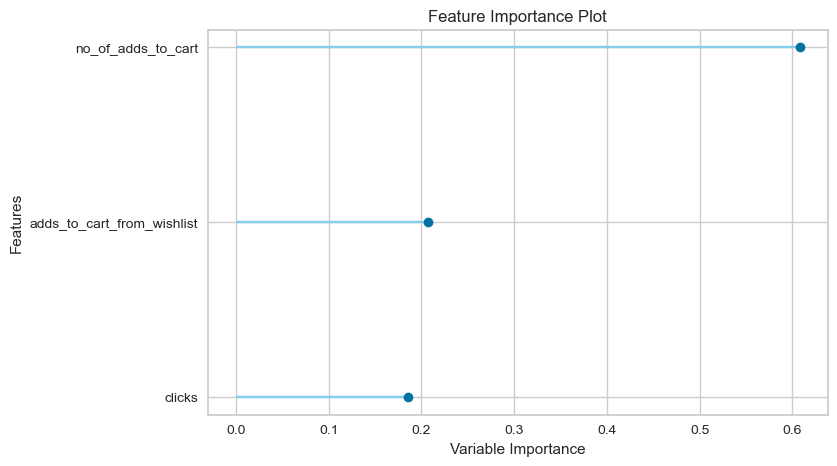

In [49]:
%matplotlib widget
plot_model(rf, plot = 'feature')

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [ ]:
best.coef_

array([0.06786794, 0.1648496 , 1.28258385])

In [51]:
xgb = create_model('xgboost', fold=15)

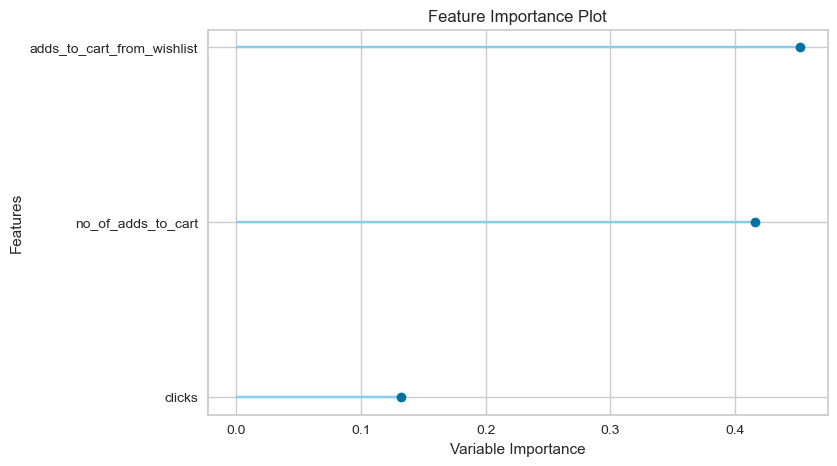

In [52]:
plot_model(xgb, plot = 'feature')

In [57]:
from sklearn.model_selection import train_test_split
import sklearn
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, StratifiedKFold
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [58]:
X = df_ml[['clicks', 'adds_to_cart_from_wishlist', 'no_of_adds_to_cart']]
Y = df_ml['no_of_unique_purchases']

In [59]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                      test_size = 0.3, random_state = 123)

## Fitting Random Forest with Cross Validation

In [60]:
rf_reg = RandomForestRegressor()
rf_reg.fit(x_train, y_train)
train_score = rf_reg.score(x_train, y_train)
train_score

0.9501940430393602

In [61]:
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [62]:
rf_regressor = RandomForestRegressor(random_state = 123)

params = {
    'bootstrap': [True],
    'max_depth': [None, 80],
    'max_features': [1, 2],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [2, 8],
    'n_estimators': [100, 1000]
}


tuned_rf_regressor = GridSearchCV(estimator=rf_regressor, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=1, cv=15)


tuned_rf_regressor.fit(x_train, y_train)
print("Best parameters:", tuned_rf_regressor.best_params_)
#print("\nLowest MAE: ", (-tuned_xgb.best_score_)**(1/2.0))
print("\nMAE: ", tuned_rf_regressor.best_score_)

Fitting 15 folds for each of 32 candidates, totalling 480 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 1000}

MAE:  -0.023557670936971267


In [63]:
y_preds = tuned_rf_regressor.best_estimator_.predict(x_test)
rf_test_accuracy = mae(y_test, y_preds)
print(f"MAE on the testing data: {rf_test_accuracy}")

MAE on the testing data: 0.03361201784271967


In [64]:
tuned_rf_regressor.best_estimator_

RandomForestRegressor(max_features=2, min_samples_leaf=3, n_estimators=1000,
                      random_state=123)

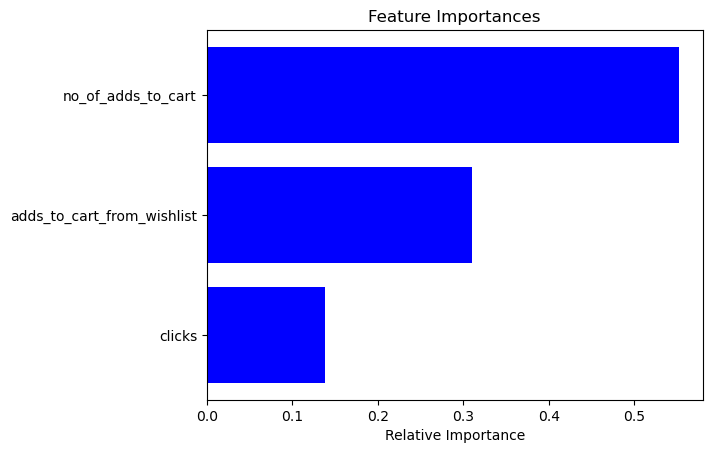

In [65]:
importances = tuned_rf_regressor.best_estimator_.feature_importances_
indices = np.argsort(importances)
features = X.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [66]:
importances_rf = importances.copy()
importances_rf
rf_imp = pd.DataFrame({'features': ['clicks', 'adds_to_cart_from_wishlist', 'no_of_adds_to_cart'], 'importance': importances_rf})
rf_imp

,features,importance
0,clicks,0.138287
1,adds_to_cart_from_wishlist,0.309573
2,no_of_adds_to_cart,0.552140


In [67]:
rf_imp.set_index('features', inplace=True)
rf_imp

,importance
features,
clicks,0.138287
adds_to_cart_from_wishlist,0.309573
no_of_adds_to_cart,0.552140


<h2>Fitting XGBRegressor with Cross Validation</h2>

In [68]:
xgb_reg = XGBRegressor()
xgb_reg.fit(x_train, y_train)
train_score = xgb_reg.score(x_train, y_train)

In [69]:
train_score

0.9998187943963767

In [70]:
xgb = XGBRegressor(seed = 123)

params = { 
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7]
}


tuned_xgb = GridSearchCV(estimator=xgb, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=1, cv=10)


tuned_xgb.fit(x_train, y_train)
print("Best parameters:", tuned_xgb.best_params_)
#print("\nLowest MAE: ", (-tuned_xgb.best_score_)**(1/2.0))
print("\nMAE: ", tuned_xgb.best_score_)

Fitting 10 folds for each of 54 candidates, totalling 540 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}

MAE:  -0.027537390111418803


In [71]:
# Predicting the Test set results
y_preds = tuned_xgb.best_estimator_.predict(x_test)
xgb_test_accuracy = mae(y_test, y_preds)
print(f"MAE on the testing data: {xgb_test_accuracy}")

MAE on the testing data: 0.03425670949616105


In [72]:
tuned_xgb.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [88]:
tuned_xgb.best_estimator_.feature_importances_

array([0.15484968, 0.31768814, 0.5274621 ], dtype=float32)

In [87]:
tuned_xgb.best_estimator_.feature_names_in_

array(['clicks', 'adds_to_cart_from_wishlist', 'no_of_adds_to_cart'],
      dtype='<U26')

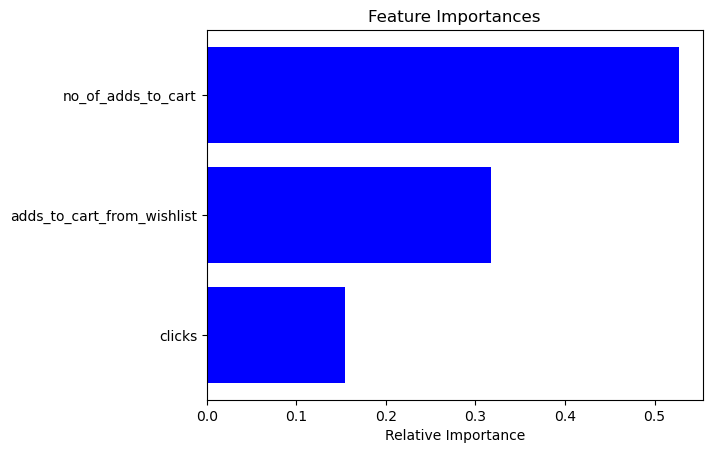

In [73]:
importances = tuned_xgb.best_estimator_.feature_importances_
indices = np.argsort(importances)
features = X.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

In [89]:
# plt.figsize=(10,10)
# ax = plot_importance(tuned_xgb.best_estimator_, importance_type='gain')
# # save the figure to file and crop to the content
# fig = ax.figure
# fig.savefig('Plots/XGB_Feature_Importance.png', bbox_inches='tight')
# #plt.savefig('Plots/XGB_Feature_Importance.png')
# plt.show()
# f_importance = tuned_xgb.best_estimator_.get_booster().get_score(importance_type='gain')
# f_importance

importances_xgb = importances.copy()
xgb_imp = pd.DataFrame({'features': tuned_xgb.best_estimator_.feature_names_in_, 'importance': tuned_xgb.best_estimator_.feature_importances_})
xgb_imp

,features,importance
0,clicks,0.154850
1,adds_to_cart_from_wishlist,0.317688
2,no_of_adds_to_cart,0.527462


In [90]:
xgb_imp.set_index('features', inplace=True)
xgb_imp

,importance
features,
clicks,0.154850
adds_to_cart_from_wishlist,0.317688
no_of_adds_to_cart,0.527462


In [99]:
print(rf_test_accuracy, xgb_test_accuracy)
if(rf_test_accuracy > xgb_test_accuracy):
    print("Random Forest is giving better performance on Regression")
    

0.03361201784271967 0.03425670949616105


## Huber Regressor

In [92]:
hbr = HuberRegressor()
hbr.fit(x_train, y_train)
hbr.score(x_train, y_train)

0.7208163872436211

In [93]:
cv = RepeatedKFold(n_splits=10, random_state=123)
final_scores = cross_val_score(hbr, x_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
hbr_best_score = abs(final_scores).mean()

In [94]:
hbr_best_score

0.027060117433914413

In [95]:
y_preds = hbr.predict(x_test)
hbr_test_accuracy = mae(y_test, y_preds)
print(f"MAE on the testing data: {hbr_test_accuracy}")

MAE on the testing data: 0.03347458204608084


In [76]:
hbr.get_params()

{'alpha': 0.0001,
 'epsilon': 1.35,
 'fit_intercept': True,
 'max_iter': 100,
 'tol': 1e-05,
 'warm_start': False}

In [77]:
feature_importance = hbr.coef_

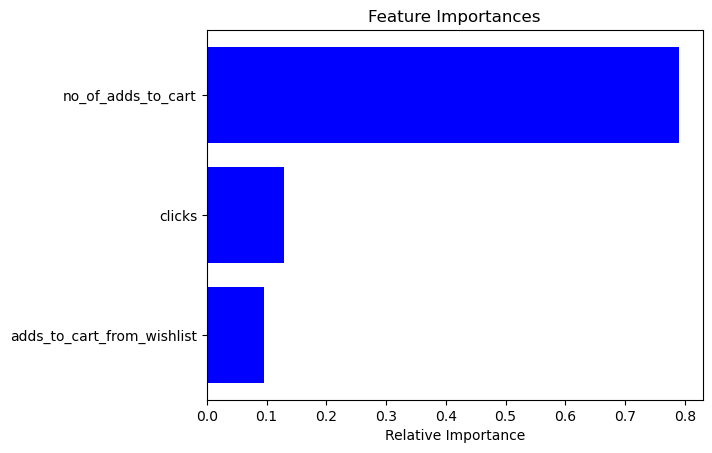

In [97]:
importances = hbr.coef_
indices = np.argsort(importances)
features = X.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

Text(0, 0.5, 'Importance')

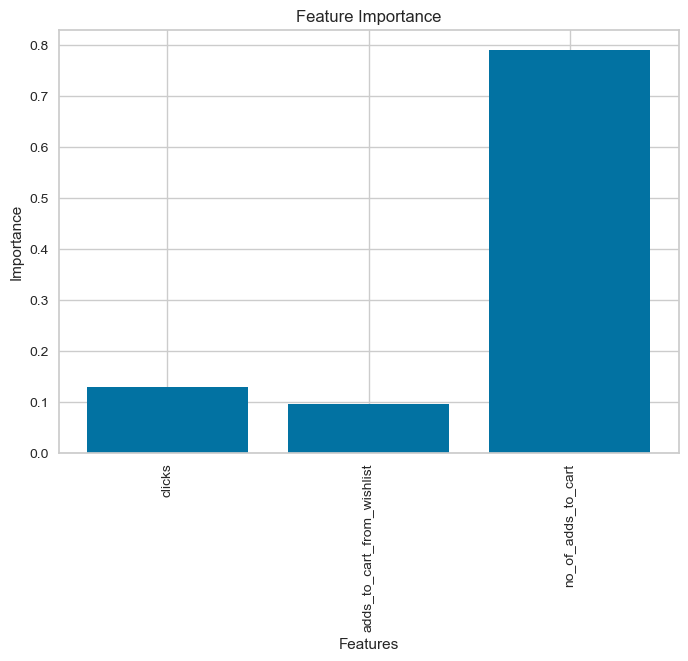

In [78]:

plt.bar(range(3), feature_importance)

# Set the x-axis ticks to feature names
plt.xticks(range(3), X.columns, rotation=90)

# Set the title and axis labels
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

In [79]:
importance_df_huber = pd.DataFrame({'feature': X.columns, 'weights': hbr.coef_})
importance_df_huber.sort_values('weights', ascending=False, inplace=True)
importance_df_huber['weights'] = importance_df_huber['weights']/importance_df_huber['weights'].sum()
importance_df_huber

,feature,weights
2,no_of_adds_to_cart,0.778058
0,clicks,0.127182
1,adds_to_cart_from_wishlist,0.094759


In [80]:
importance_df_huber.set_index('feature', inplace=True)
importance_df_huber

,weights
feature,
no_of_adds_to_cart,0.778058
clicks,0.127182
adds_to_cart_from_wishlist,0.094759


In [84]:
dict1 = {}
dict1['RandomForest'] = abs(tuned_rf_regressor.best_score_)
dict1['XGBoost'] = abs(tuned_xgb.best_score_)
dict1['HuberRegressor'] = hbr_best_score
df_results = pd.DataFrame.from_dict(dict1, orient='index', columns=['MAE'])
df_results

,MAE
RandomForest,0.026159
XGBoost,0.026456
HuberRegressor,0.028329


In [85]:
print("Model with best MAE: ", df_results['MAE'].idxmin())

Model with best MAE:  RandomForest


<h2>Caclulating Popularity Score based on the weights</h2>

## 1. Random Forest

In [101]:
df_joined_brand
df_X = df_joined_brand[['brand', 'clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_purchases']].copy()

df_X = df_joined_brand.apply(lambda x: (x-x.min())/(x.max()-x.min()) if(type(x[0]) != str) else x)
df_X

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart
0,18.21 Man Made,0.014578,0.000000,0.000000,0.045283,0.023891
1,23 Yards,0.001831,0.053333,0.004301,0.007547,0.008532
2,4711,0.002124,0.000000,0.000000,0.015094,0.006361
3,A Fragrance Story,0.005934,0.003810,0.004301,0.000000,0.006516
4,AND,0.031353,0.024762,0.027957,0.181132,0.144896
...,...,...,...,...,...,...
304,Xx Revolution,0.006593,0.001905,0.002151,0.007547,0.002327
305,YC,0.000733,0.001905,0.002151,0.000000,0.000621
306,Yves Rocher,0.047030,0.068571,0.055914,0.030189,0.089823
307,ZM Zayn & Myza,0.013772,0.013333,0.015054,0.015094,0.012101


In [113]:
df_ml

,brand,clicks,adds_to_cart_from_wishlist,no_of_adds_to_cart,no_of_unique_purchases
0,18.21 Man Made,0.014578,0.045283,0.023891,0.000000
1,23 Yards,0.001831,0.007547,0.008532,0.004301
2,4711,0.002124,0.015094,0.006361,0.000000
3,A Fragrance Story,0.005934,0.000000,0.006516,0.004301
4,AND,0.031353,0.181132,0.144896,0.027957
...,...,...,...,...,...
304,Xx Revolution,0.006593,0.007547,0.002327,0.002151
305,YC,0.000733,0.000000,0.000621,0.002151
306,Yves Rocher,0.047030,0.030189,0.089823,0.055914
307,ZM Zayn & Myza,0.013772,0.015094,0.012101,0.015054


In [102]:
rf_imp

,importance
features,
clicks,0.138287
adds_to_cart_from_wishlist,0.309573
no_of_adds_to_cart,0.552140


In [132]:
if (max(rf_imp['importance']) > 0.5):
    w_purchase = max(rf_imp['importance']) - 0.15
else:
    w_purchase = max(rf_imp['importance']) + 0.15
w_purchase

0.40214025998240954

In [121]:
w_purchase = 0.5
w_clicks = rf_imp.loc['clicks', 'importance'] * 0.5
w_wishlist = rf_imp.loc['adds_to_cart_from_wishlist', 'importance'] * 0.5
w_cart = rf_imp.loc['no_of_adds_to_cart', 'importance'] * 0.5

w_purchase + w_clicks + w_wishlist + w_cart

1.0

In [122]:
w_clicks

0.06914353767620732

In [123]:
w_wishlist

0.15478633233258796

In [124]:
w_cart

0.2760701299912048

In [111]:
df_popularity_fin = df_X
df_popularity_fin['popularity_score'] = (df_X['no_of_purchases'] * w_purchase + df_X['clicks'] * w_clicks + df_X['no_of_adds_to_wishlist'] * w_wishlist + df_X['no_of_adds_to_cart'] * w_cart)/(w_purchase + w_clicks + w_wishlist + w_cart)

In [112]:
df_popularity_fin.sort_values('popularity_score', ascending=False, inplace=True)
df_popularity_fin

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart,popularity_score
68,Colorbar,0.700315,0.662857,0.701075,1.000000,1.000000,0.840277
154,Lakme,0.762362,1.000000,1.000000,0.611321,0.493019,0.740133
168,M.A.C,0.982785,0.558095,0.462366,0.754717,0.878219,0.735906
181,Maybelline New York,1.000000,0.655238,0.662366,0.573585,0.550419,0.633952
229,Plum,0.337338,0.649524,0.658065,0.633962,0.477816,0.563846
...,...,...,...,...,...,...,...
37,Bhu Botanicals,0.000879,0.000000,0.000000,0.000000,0.000776,0.000330
169,MADES,0.001319,0.000000,0.000000,0.000000,0.000621,0.000315
51,BrownSkin Beauty,0.000806,0.000000,0.000000,0.000000,0.000621,0.000272
236,Qurez,0.000879,0.000000,0.000000,0.000000,0.000465,0.000227


## 1. XGB

In [262]:
df_joined_brand

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart
0,23 Yards,18,2.0,2,11,27
1,4711,29,1.0,1,12,41
2,A Fragrance Story,57,3.0,3,14,27
3,AND,227,4.0,4,131,271
4,AXE,94,20.0,18,19,110
...,...,...,...,...,...,...
315,YC,7,2.0,2,3,6
316,Yardley London,8,1.0,1,1,8
317,Yves Rocher,275,17.0,15,43,394
318,ZM Zayn & Myza,96,6.0,6,25,60


In [263]:
df_X = df_joined_brand[['brand', 'clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_purchases']].copy()

df_X = df_joined_brand.apply(lambda x: (x-x.min())/(x.max()-x.min()) if(type(x[0]) != str) else x)
df_X

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart
0,23 Yards,0.002289,0.002625,0.002849,0.005935,0.004359
1,4711,0.003770,0.000000,0.000000,0.006528,0.006706
2,A Fragrance Story,0.007539,0.005249,0.005698,0.007715,0.004359
3,AND,0.030425,0.007874,0.008547,0.077151,0.045264
4,AXE,0.012520,0.049869,0.048433,0.010682,0.018273
...,...,...,...,...,...,...
315,YC,0.000808,0.002625,0.002849,0.001187,0.000838
316,Yardley London,0.000942,0.000000,0.000000,0.000000,0.001174
317,Yves Rocher,0.036887,0.041995,0.039886,0.024926,0.065884
318,ZM Zayn & Myza,0.012789,0.013123,0.014245,0.014243,0.009891


In [281]:
w_purchase = 0.5
w_clicks = importance_df.loc['clicks', 'weights'] * 0.5
w_wishlist = importance_df.loc['no_of_adds_to_wishlist', 'weights'] * 0.5
w_cart = importance_df.loc['no_of_adds_to_cart', 'weights'] * 0.5

w_purchase + w_clicks + w_wishlist + w_cart

1.0

In [282]:
w_clicks

0.019608006712274827

In [283]:
w_wishlist

0.06831771745761436

In [284]:
w_cart

0.4120742758301108

In [285]:
w_purchase

0.5

In [286]:
df_popularity_fin = df_X
df_popularity_fin['popularity_score'] = (df_X['no_of_purchases'] * w_purchase + df_X['clicks'] * w_clicks + df_X['no_of_adds_to_wishlist'] * w_wishlist + df_X['no_of_adds_to_cart'] * w_cart)/(w_purchase + w_clicks + w_wishlist + w_cart)

In [287]:
df_popularity_fin.sort_values('popularity_score', ascending=False, inplace=True)

In [288]:
scaler = MinMaxScaler()
df_popularity_fin['popularity_score'] = scaler.fit_transform(df_popularity_fin[['popularity_score']])
df_popularity_fin

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart,popularity_score
71,Colorbar,1.000000,0.729659,0.746439,1.000000,1.000000,1.000000
152,Lakme,0.863355,1.000000,1.000000,0.284273,0.296060,0.761247
165,M.A.C,0.980749,0.406824,0.296296,0.529377,0.633697,0.601204
180,Maybelline New York,0.802908,0.616798,0.601140,0.346588,0.384577,0.585427
96,Estee Lauder,0.829429,0.496063,0.239316,0.299110,0.284996,0.465027
...,...,...,...,...,...,...,...
89,ELINOR,0.001481,0.000000,0.000000,0.000000,0.000335,0.000193
117,Herbal Me,0.001346,0.000000,0.000000,0.000000,0.000335,0.000190
286,The Tribe Concepts,0.001212,0.000000,0.000000,0.000000,0.000335,0.000187
143,Kora Organics,0.001077,0.000000,0.000000,0.000000,0.000000,0.000024


## 2. Huber

In [300]:
df_joined_brand

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart
0,23 Yards,18,2.0,2,11,27
1,4711,29,1.0,1,12,41
2,A Fragrance Story,57,3.0,3,14,27
3,AND,227,4.0,4,131,271
4,AXE,94,20.0,18,19,110
...,...,...,...,...,...,...
315,YC,7,2.0,2,3,6
316,Yardley London,8,1.0,1,1,8
317,Yves Rocher,275,17.0,15,43,394
318,ZM Zayn & Myza,96,6.0,6,25,60


In [301]:
df_X = df_joined_brand[['brand', 'clicks', 'no_of_adds_to_wishlist', 'no_of_adds_to_cart', 'no_of_purchases']].copy()

df_X = df_joined_brand.apply(lambda x: (x-x.min())/(x.max()-x.min()) if(type(x[0]) != str) else x)
df_X

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart
0,23 Yards,0.002289,0.002625,0.002849,0.005935,0.004359
1,4711,0.003770,0.000000,0.000000,0.006528,0.006706
2,A Fragrance Story,0.007539,0.005249,0.005698,0.007715,0.004359
3,AND,0.030425,0.007874,0.008547,0.077151,0.045264
4,AXE,0.012520,0.049869,0.048433,0.010682,0.018273
...,...,...,...,...,...,...
315,YC,0.000808,0.002625,0.002849,0.001187,0.000838
316,Yardley London,0.000942,0.000000,0.000000,0.000000,0.001174
317,Yves Rocher,0.036887,0.041995,0.039886,0.024926,0.065884
318,ZM Zayn & Myza,0.012789,0.013123,0.014245,0.014243,0.009891


In [302]:
w_purchase = 0.5
w_clicks = importance_df_huber.loc['clicks', 'weights'] * 0.5
w_wishlist = importance_df_huber.loc['no_of_adds_to_wishlist', 'weights'] * 0.5
w_cart = importance_df_huber.loc['no_of_adds_to_cart', 'weights'] * 0.5

w_purchase + w_clicks + w_wishlist + w_cart

1.0

In [303]:
w_clicks

0.0223942337557692

In [304]:
w_wishlist

0.05439495122992581

In [305]:
w_cart

0.423210815014305

In [306]:
df_popularity_fin = df_X
df_popularity_fin['popularity_score'] = (df_X['no_of_purchases'] * w_purchase + df_X['clicks'] * w_clicks + df_X['no_of_adds_to_wishlist'] * w_wishlist + df_X['no_of_adds_to_cart'] * w_cart)/(w_purchase + w_clicks + w_wishlist + w_cart)

In [307]:
df_popularity_fin.sort_values('popularity_score', ascending=False, inplace=True)

In [308]:
scaler = MinMaxScaler()
df_popularity_fin['popularity_score'] = scaler.fit_transform(df_popularity_fin[['popularity_score']])
df_popularity_fin

,brand,clicks,no_of_purchases,no_of_unique_purchases,no_of_adds_to_wishlist,no_of_adds_to_cart,popularity_score
71,Colorbar,1.000000,0.729659,0.746439,1.000000,1.000000,1.000000
152,Lakme,0.863355,1.000000,1.000000,0.284273,0.296060,0.763264
165,M.A.C,0.980749,0.406824,0.296296,0.529377,0.633697,0.604001
180,Maybelline New York,0.802908,0.616798,0.601140,0.346588,0.384577,0.587386
96,Estee Lauder,0.829429,0.496063,0.239316,0.299110,0.284996,0.466554
...,...,...,...,...,...,...,...
89,ELINOR,0.001481,0.000000,0.000000,0.000000,0.000335,0.000202
117,Herbal Me,0.001346,0.000000,0.000000,0.000000,0.000335,0.000199
286,The Tribe Concepts,0.001212,0.000000,0.000000,0.000000,0.000335,0.000195
143,Kora Organics,0.001077,0.000000,0.000000,0.000000,0.000000,0.000028
